In [3]:
import numpy as np # xử lý mảng bên đại số tuyến tính
import pandas as pd 
import matplotlib.pyplot as plt #vẽ hình
import os
import h5py
import shutil
import glob
import seaborn as sn
import imgaug as aug
from PIL import Image
from pathlib import Path
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from skimage.io import imread
from skimage.transform import resize
import keras
import imgaug.augmenters as iaa
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
#from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K
color = sn.color_palette()
print(os.listdir("../X-ray/input"))


Using TensorFlow backend.


['chest_xray', 'VGG16']


In [4]:
# khởi tạo các tham số ngẫu nhiên cho tensorflow và keras
import tensorflow as tf
# thiết lập seed cho những hoạt động dựa trên hàm băm ở python
os.environ['PYTHONHASHSEED'] = '0' 
# thiết lập hàm tạo tham số ngẫu nhiên để đối chiếu giữa các lần cập nhật tham số 
np.random.seed(111) 
# vô hiệu đa luồng trong tensorflow ops
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#thiết lập hàm tạo tham số ngẫu nhiên trong tensorflow tại mức đồ thị
tf.set_random_seed(111)
# xác định 1 phiên tensorflow với cấu hình phiên làm việc ở trên
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf) 
# thiết lập phiên làm việc trong keras
K.set_session(sess)

#xác định chuỗi tăng cường (augmentation sequence)
aug.seed(111)

In [5]:
#xác định đường dẫn đến thư mục dữ liệu 
#print(os.listdir(train_folder))
Data_main =Path( '../X-ray/input/chest_xray/chest_xray')
print(os.listdir(Data_main))
# đường dẫn đến thư mục train
train_dir = Data_main / 'train'

# đường dẫn đến thư mục val
val_dir = Data_main / 'val'

# đường dẫn đến thư mục test
test_dir = Data_main / 'test'
print(os.listdir(train_dir))

['.DS_Store', 'test', 'train', 'val']
['NORMAL', 'PNEUMONIA']


In [5]:
# lấy đường dẫn đến thư mục con normal and pneumonia của thư mục train
train_n = train_dir / 'NORMAL'
train_p = train_dir / 'PNEUMONIA'

# lấy danh sách tất cả hình ảnh 
normal_cases = train_n.glob('*.jpeg')
pneumonia_cases = train_p.glob('*.jpeg')

In [4]:
#chuẩn bị dữ liệu training
train_n = train_dir / 'NORMAL'
train_p = train_dir / 'PNEUMONIA'

# lấy danh sách tất cả hình ảnh 
normal_cases = train_n.glob('*.jpeg')
pneumonia_cases = train_p.glob('*.jpeg')
# thử liệt kê các ảnh trong 2 thư mục normal và pneumonia của thư mục train bằng cách chèn dữ liệu của 2 thư mục này vào trong một list trống

t_data=[]
# ta gán tất cả ảnh trong normal_cases với nhãn là 0
for img in normal_cases:
    t_data.append((img,0))
    
# gán tất cả ảnh trong pneumonia_cases với nhãn là 1
for img in pneumonia_cases:
    t_data.append((img,1))
# cho dữ liệu mà ta có trong danh sách vào 1 pandas dataframe
t_data = pd.DataFrame(t_data, columns=['image', 'label'],index=None)
# trộn dữ liệu
t_data = t_data.sample(frac=1.).reset_index(drop=True)
t_data.head(len(t_data))
#print(t_data)

,image,label
0,..\X-ray\input\chest_xray\chest_xray\train\NOR...,0
1,..\X-ray\input\chest_xray\chest_xray\train\NOR...,0
2,..\X-ray\input\chest_xray\chest_xray\train\PNE...,1
3,..\X-ray\input\chest_xray\chest_xray\train\PNE...,1
4,..\X-ray\input\chest_xray\chest_xray\train\PNE...,1
5,..\X-ray\input\chest_xray\chest_xray\train\NOR...,0
6,..\X-ray\input\chest_xray\chest_xray\train\PNE...,1
7,..\X-ray\input\chest_xray\chest_xray\train\NOR...,0
8,..\X-ray\input\chest_xray\chest_xray\train\NOR...,0
9,..\X-ray\input\chest_xray\chest_xray\train\PNE...,1


1    3875
0    1341
Name: label, dtype: int64


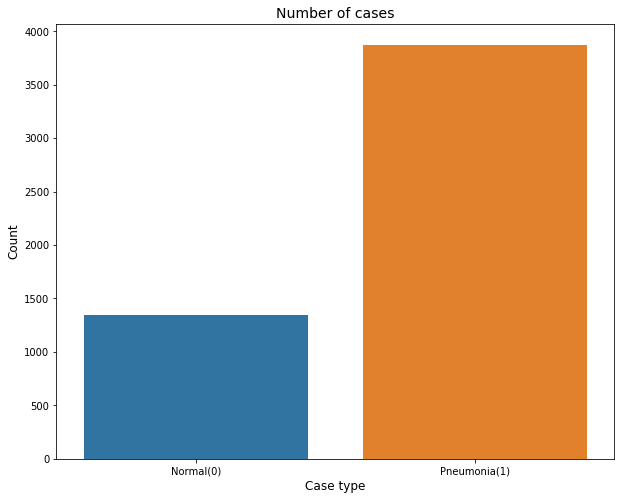

In [5]:
# lấy số lượng ảnh của mỗi label
cases_count = t_data['label'].value_counts()
print(cases_count)

# vẽ biểu đồ biểu thị tương quan về số lượng mỗi nhãn  
plt.figure(figsize=(10,8))
sn.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

1341
normal picture title:  IM-0472-0001.jpeg
3875
pneumonia picture title: person1582_bacteria_4143.jpeg


Text(0.5,1,'Pneumonia')

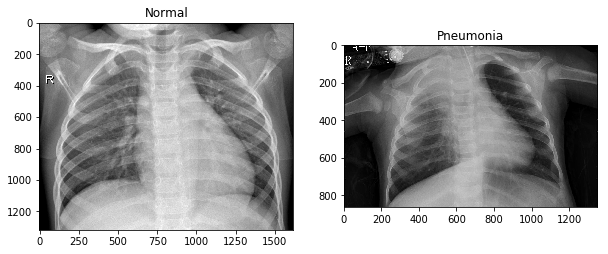

In [6]:
#xem một vài ảnh từ 2 thư mục normal và pneumonia trong train folder
train_dir= '../X-ray/input/chest_xray/chest_xray/train/'
val_dir = '../X-ray/input/chest_xray/chest_xray/val/'
test_dir = '../X-ray/input/chest_xray/chest_xray/test/'

train_n = train_dir + 'NORMAL/'
train_p = train_dir + 'PNEUMONIA/'

#Normal pic 
print(len(os.listdir(train_n)))
rand_norm= np.random.randint(0,len(os.listdir(train_n)))
norm_pic = os.listdir(train_n)[rand_norm]
norm_pic_address = train_n+norm_pic
print('normal picture title: ',norm_pic)

#Pneumonia pic
print(len(os.listdir(train_p)))
rand_p = np.random.randint(0,len(os.listdir(train_p)))
sic_pic =  os.listdir(train_p)[rand_p]
sic_address = train_p+sic_pic
print('pneumonia picture title:', sic_pic)

# Load the images
norm_load = Image.open(norm_pic_address)
sic_load = Image.open(sic_address)

#hiển thị ảnh 
f = plt.figure(figsize= (10,6))
a1 = f.add_subplot(1,2,1)
img_plot = plt.imshow(norm_load)
a1.set_title('Normal')

a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(sic_load)
a2.set_title('Pneumonia')

In [6]:
## Augmentation sequence 
seq = iaa.OneOf([
    iaa.Fliplr(), # lật ngang
    iaa.Affine(rotate=20), # xoay ảnh
    iaa.Multiply((1.2, 1.5))]) #độ sáng ngẫu nhiên 
#chuẩn bị dữ liệu training
train_dir = Data_main / 'train'

train_n = train_dir / 'NORMAL'
train_p = train_dir / 'PNEUMONIA'

# lấy danh sách tất cả hình ảnh 
normal_cases = train_n.glob('*.jpeg')
pneumonia_cases = train_p.glob('*.jpeg')

train_data = []
train_labels = []
 
#chuẩn hóa giá trị pixel ảnh và resize tất cả ảnh tới kích thước 64x64

# Normal cases, tăng gấp đôi số lượng ảnh trong mục normal_cases để số ảnh không bị bệnh ngang ngửa số ảnh bị bệnh
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64,64))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    aug_img1 = seq.augment_image(img)
    aug_img2 = seq.augment_image(img)
    aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB) # đọc trong chế độ ảnh màu 
    aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
    aug_img1 = aug_img1.astype(np.float32)/255. #chuẩn hóa pixel ảnh 
    aug_img2 = aug_img2.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    train_data.append(aug_img1)
    train_labels.append(label)
    train_data.append(aug_img2)
    train_labels.append(label)
                      
# Pneumonia cases        
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64,64))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    train_data.append(img)
    train_labels.append(label)
    
# chuyển list thành mảng numpy để xử lý tensor
train_data = np.array(train_data)
train_labels = np.array(train_labels)
print(train_data.shape)

(6557, 64, 64, 3)


In [7]:
# đường dẫn đến thư mục val
val_dir = Data_main / 'val'

val_n = val_dir / 'NORMAL'
val_p = val_dir / 'PNEUMONIA'

# lấy danh sách tất cả hình ảnh 
normal_val = val_n.glob('*.jpeg')
pneumonia_val = val_p.glob('*.jpeg')

valid_data = []
valid_labels = []
 
# Normal cases
for img in normal_val:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64,64))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
                      
# Pneumonia cases        
for img in pneumonia_val:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64,64))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
    
# chuyển list thành mảng numpy, keras yêu cầu
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)
print(valid_data.shape)

(16, 64, 64, 3)


In [8]:
# định nghĩa mô hình
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv1_1', input_shape=(64,64,3)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv1_2'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1'))
model.add(SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2'))
model.add(MaxPooling2D(2,2))

model.add(SeparableConv2D(256, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(SeparableConv2D(256, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(SeparableConv2D(256, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2)))

model.add(SeparableConv2D(512, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(SeparableConv2D(512, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(SeparableConv2D(512, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2)))
   
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1_1 (Conv2D)             (None, 64, 64, 64)        1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 32, 32, 128)       8896      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 32, 32, 128)       17664     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 16, 16, 256)     

In [9]:
# mở file weight từ pre-trained của VGG16
f = h5py.File('../X-ray/input/VGG16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'r')

# chọn layer mà bạn muốn gán weights

w,b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']
model.layers[1].set_weights = [w,b]

w,b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']
model.layers[2].set_weights = [w,b]

w,b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']
model.layers[4].set_weights = [w,b]

w,b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']
model.layers[5].set_weights = [w,b]

f.close()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1_1 (Conv2D)             (None, 64, 64, 64)        1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 32, 32, 128)       8896      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 32, 32, 128)       17664     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 16, 16, 256)      

In [6]:
epochs = 10
opt = Adam(lr = 0.0001, decay = 0.0001/epochs)
#validation_data=(valid_data, valid_labels),

In [10]:
# biên dịch mô hình, chỉ rõ hàm loss_function nào được sử dụng, phương thức dùng để tối ưu hàm loss function.
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
batch_size=16 #Là size trong mini-batch gradient descent, nghĩa là dùng bao nhiêu dữ liệu cho mỗi lần tính và cập nhật hệ số
#steps_per_epoch = len(t_data)//batch_size # số lần thực hiện bước 2 trong gradient descent trong mỗi epoch
es = EarlyStopping(patience=5) # dung train neu tham so quan sat khong kha len sau 5 epochs
ch = ModelCheckpoint(filepath='file_weight_model_1', save_best_only=True, save_weights_only=True) # lưu file weight

In [11]:
# Thực hiện huấn luyện mô hình với data
H = model.fit(train_data, train_labels, validation_data = (valid_data, valid_labels), batch_size = 16, epochs = 20,
          callbacks=[es, ch], class_weight={0:1.0, 1:0.7}, verbose = 1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 6557 samples, validate on 16 samples
Epoch 1/20
6557/6557 [==============================] - 1370s 209ms/step - loss: 0.2410 - accuracy: 0.8725 - val_loss: 0.8726 - val_accuracy: 0.5000
Epoch 2/20
6557/6557 [==============================] - 1071s 163ms/step - loss: 0.1294 - accuracy: 0.9448 - val_loss: 0.6905 - val_accuracy: 0.5625
Epoch 3/20
6557/6557 [==============================] - 640s 98ms/step - loss: 0.1220 - accuracy: 0.9503 - val_loss: 2.0434 - val_accuracy: 0.5000
Epoch 4/20
6557/6557 [==============================] - 627s 96ms/step - loss: 0.1150 - accuracy: 0.9517 - val_loss: 0.6283 - val_accuracy: 0.8125
Epoch 5/20
6557/6557 [==============================] - 627s 96ms/step - loss: 0.0865 - accuracy: 0.9664 - val_loss: 5.0737 - val_accuracy: 0.5000
Epoch 6/20
6557/6557 [==============================] - 625s 95ms/step - loss: 0.0792 - accuracy: 0.9674 - val_loss: 1.6

In [ ]:
# tải file weight đã được lưu sau khi huấn luyện xong mô hình nếu bạn không muốn chạy qua bước huấn luyện mất 
# thời gian chừng 60 phút 
model.load_weights("../X-ray/file_weight_model_hay_xua")


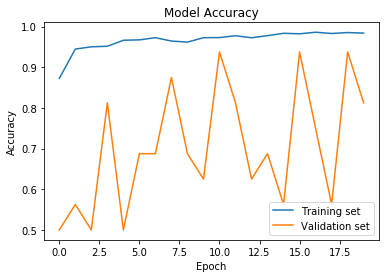

In [12]:
# Accuracy 
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='lower right')
plt.show()

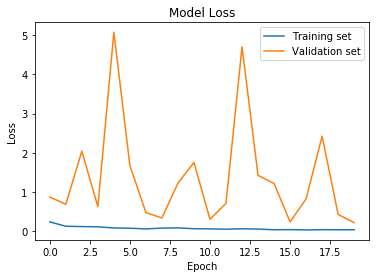

In [13]:
# Loss 
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper right')
plt.show()

In [14]:
# kiểm thử mô hình
# đường dẫn đến thư mục test
Data_main =Path( '../X-ray/input/chest_xray/chest_xray')
test_dir = Data_main / 'test'

test_n = test_dir / 'NORMAL'
test_p = test_dir / 'PNEUMONIA'

# lấy danh sách tất cả hình ảnh 
normal_test = test_n.glob('*.jpeg')
pneumonia_test = test_p.glob('*.jpeg')

test_data_t = []
test_labels_t = []
 
# Normal cases
for img in normal_test:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64,64))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data_t.append(img)
    test_labels_t.append(label)
                      
# Pneumonia cases        
for img in pneumonia_test:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64,64))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data_t.append(img)
    test_labels_t.append(label)
    
# chuyển list thành mảng numpy
test_data = np.array(test_data_t)
test_labels = np.array(test_labels_t)
print(test_data.shape)
print(test_labels.shape)

(624, 64, 64, 3)
(624, 2)


In [15]:
# Đánh giá mô hình với dữ liệu test
loss, accuracy = model.evaluate(test_data, test_labels, batch_size = 16)
print("giá trị hàm mất mát trên tập test: ", loss)
print("độ chính xác trên tập test: ", accuracy)

624/624 [==============================] - 13s 21ms/step
giá trị hàm mất mát trên tập test:  0.9187579871872097
độ chính xác trên tập test:  0.8605769276618958


In [16]:
predict = model.predict(test_data, batch_size = 16)
y_predict = np.argmax(predict, axis = -1)
orig_test_labels = np.argmax(test_labels, axis = -1)
print(y_predict.shape)
print(orig_test_labels.shape)
print(y_predict)

(624,)
(624,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 1 1 0 0 0 1 1
 0 0 0 0 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1
 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 0
 0 1 0 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0
 0 1 0 0 1 0 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 

[[163  71]
 [ 16 374]]


<Figure size 432x288 with 0 Axes>

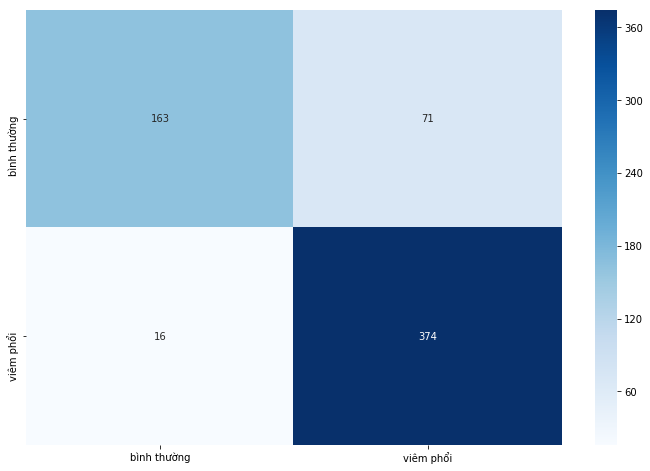

In [17]:
cm  = confusion_matrix(orig_test_labels, y_predict)
print(cm)
plt.figure()
df_cm = pd.DataFrame(cm, index = [i for i in ["bình thường", "viêm phổi"]],
                  columns = [i for i in ["bình thường", "viêm phổi"]])
plt.figure(figsize = (12,8))
sn.heatmap(df_cm, annot=True, fmt="d",cmap=plt.cm.Blues)
plt.show()

In [18]:
from sklearn.metrics import accuracy_score
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)
accuracy = accuracy_score(orig_test_labels, y_predict)

print("Recall của mô hình trên tập test là {:.2f}".format(recall))
print("Precision của mô hình trên tập test là {:.2f}".format(precision))
print('Accuracy của mô hình trên tập test là %.2f' % accuracy)

Recall của mô hình trên tập test là 0.96
Precision của mô hình trên tập test là 0.84
Accuracy của mô hình trên tập test là 0.86


ảnh này bị viêm phổi


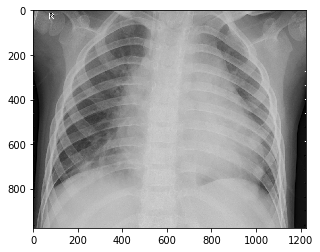

In [34]:
# thực hiện dự đoán thực tế của mô hình với ảnh lấy trong tập test gồm 624 ảnh gồm 2 loại bị bệnh và không bị bệnh
Y_pred = model.predict(test_data[392].reshape(1,64,64,3))
y = np.argmax(Y_pred)
if y==1:
    print('ảnh này bị viêm phổi')
else:
    print('ảnh này bình thường')
normal_test = test_n.glob('*.jpeg')
pneumonia_test = test_p.glob('*.jpeg')
b = []
for img in normal_test:
    img = cv2.imread(str(img))
    b.append(img)
for img in pneumonia_test:
    img = cv2.imread(str(img))
    b.append(img)
plt.imshow(b[392], cmap = 'gray')
plt.show()

390


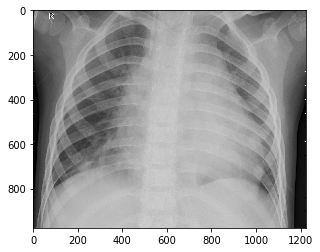

In [45]:
# thử hiển thị ảnh thứ 393 trong tập test tức ảnh thứ 158 trong thư mục bị bệnh (pneumonia)
#normal_test = test_n.glob('*.jpeg')
pneumonia_test = test_p.glob('*.jpeg')
f = []
for img in pneumonia_test:
    f.append(img)
print(len(f))
img  = imread(f[158])
plt.imshow(img, cmap = 'gray')
plt.show()
# đúng là ảnh này bị viêm phổi vì nằm trong thư mục bị bệnh đã được bác sĩ phân loại trước